In [1]:
!pip install torch

!pip install torchsummary

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

# 데이터 분할
from sklearn.model_selection import train_test_split
# 데이터 정규화
from sklearn.preprocessing import StandardScaler


In [3]:
# 데이터 로딩
file_path = "D:/files/diabetes.csv"

df = pd.read_csv(file_path)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [5]:
# 결측치 확인
df.isnull().sum()

#결측치가 있다면 제거
#df = df.dropna()
#df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
# 레이블 확인
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [7]:
X = df.drop(columns=['Outcome']).values
y = df['Outcome'].values

# 데이터 분할 및 전처리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 8), (154, 8), (614,), (154,))

In [9]:
# Convert to PyTorch tensors
# Convert to PyTorch tensors (이진 분류용으로 수정)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [10]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

In [12]:
class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x)) 
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesDense()

In [13]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).int()

        # 레이블도 int로 맞추고 shape 맞추기
            labels = labels.int()
        
            correct += (predicted.view(-1) == labels.view(-1)).sum().item()
            total += labels.size(0)

            accuracy = 100 * correct / total

    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/30, Loss: 0.6462, Accuracy: 68.83%
Epoch 2/30, Loss: 0.5785, Accuracy: 71.43%
Epoch 3/30, Loss: 0.5277, Accuracy: 75.97%
Epoch 4/30, Loss: 0.4866, Accuracy: 75.97%
Epoch 5/30, Loss: 0.4687, Accuracy: 77.92%
Epoch 6/30, Loss: 0.4564, Accuracy: 74.68%
Epoch 7/30, Loss: 0.4585, Accuracy: 75.97%
Epoch 8/30, Loss: 0.4407, Accuracy: 75.32%
Epoch 9/30, Loss: 0.4404, Accuracy: 74.68%
Epoch 10/30, Loss: 0.4236, Accuracy: 74.68%
Epoch 11/30, Loss: 0.4458, Accuracy: 74.68%
Epoch 12/30, Loss: 0.4312, Accuracy: 75.32%
Epoch 13/30, Loss: 0.4190, Accuracy: 75.32%
Epoch 14/30, Loss: 0.4382, Accuracy: 75.32%
Epoch 15/30, Loss: 0.4436, Accuracy: 75.97%
Epoch 16/30, Loss: 0.4365, Accuracy: 76.62%
Epoch 17/30, Loss: 0.4256, Accuracy: 75.32%
Epoch 18/30, Loss: 0.4277, Accuracy: 76.62%
Epoch 19/30, Loss: 0.4550, Accuracy: 75.97%
Epoch 20/30, Loss: 0.4229, Accuracy: 75.97%
Epoch 21/30, Loss: 0.4163, Accuracy: 77.27%
Epoch 22/30, Loss: 0.4088, Accuracy: 77.27%
Epoch 23/30, Loss: 0.4302, Accuracy: 76.6

In [15]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).int()  # 확률이 0.5 초과이면 1로 예측
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())


# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[80 19]
 [18 37]]
F1 Score: 0.76
Precision: 0.76
Recall: 0.76
Specificity: 0.74


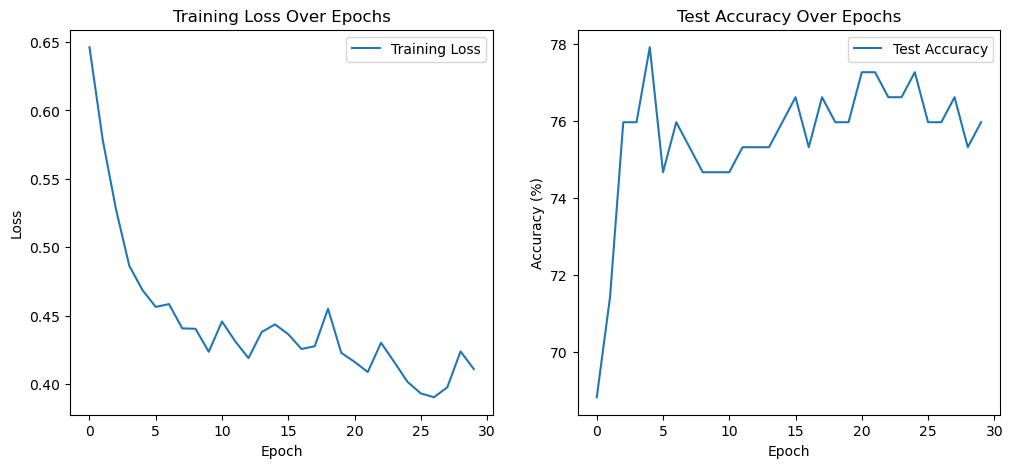

In [16]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()